<a href="https://colab.research.google.com/github/Suhail372/Hate_speech_detection_using_ML/blob/main/Model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
df = pd.read_csv('hate_speech_1.csv')
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.shape

(24783, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


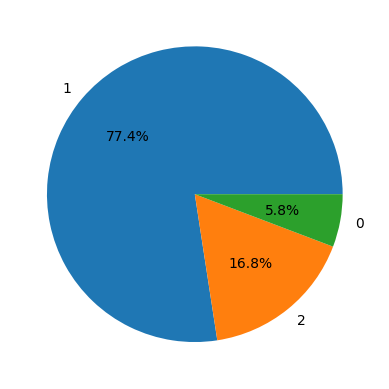

In [5]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [6]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


In [7]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():

		if word not in stop_words:

			# Let's Lemmatize the word as well
			# before appending to the imp_words list.

			lemmatizer = WordNetLemmatizer()
			lemmatizer.lemmatize(word)

			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,class,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


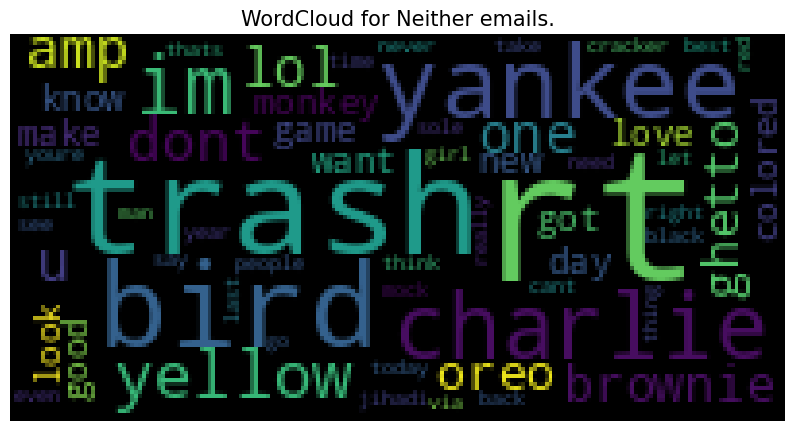

In [8]:
def plot_word_cloud(data, typ):
# Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
          width = 200,
          height = 100,
          collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')

In [9]:
id_2 = df[df['class'] == 2]
id_1 = df[df['class'] == 1]
id_0 = df[df['class'] == 0]

balanced_df = pd.concat([id_0, id_0, id_0, id_1, id_2], axis=0)


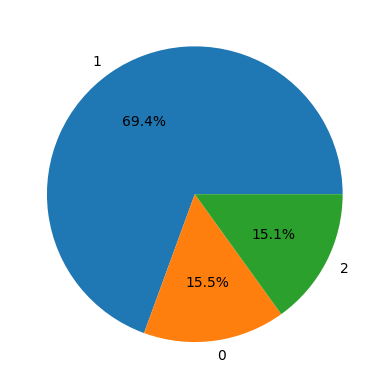

In [10]:
plt.pie(balanced_df['class'].value_counts().values,
		labels=balanced_df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()

In [11]:

features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
X_train.shape, X_val.shape

((22114,), (5529,))

In [12]:

Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((22114, 3), (5529, 3))

In [13]:
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')

token.fit_on_texts(X_train)

In [14]:
# training the tokenizer
max_words = 5000
train_X = X_train  # Assuming X_train contains your training text data
token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')
token.fit_on_texts(train_X)

#Generating token embeddings
Training_seq = token.texts_to_sequences(train_X)
Training_pad = pad_sequences(Training_seq,
							maxlen=100,
							padding='post',
							truncating='post')
test_X = X_val  # Assuming X_val contains your validation text data
Testing_seq = token.texts_to_sequences(test_X)
Testing_pad = pad_sequences(Testing_seq,
							maxlen=100,
							padding='post',
							truncating='post')

In [15]:
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

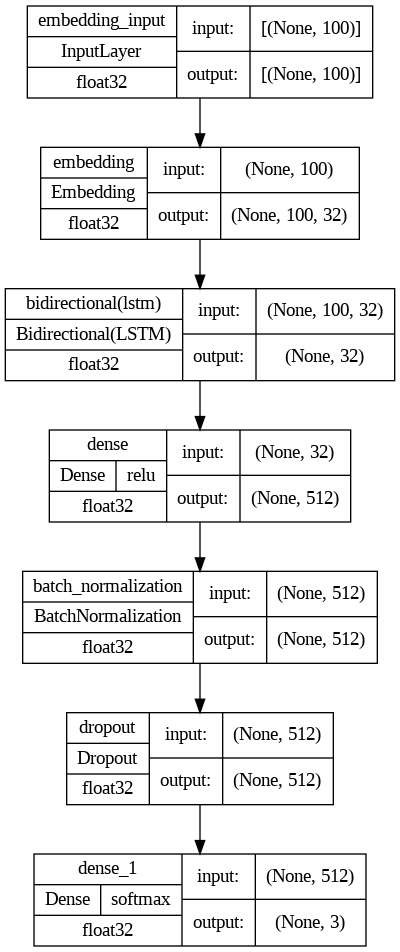

In [16]:
keras.utils.plot_model(
	model,
	show_shapes=True,
	show_dtype=True,
	show_layer_activations=True
)

# New Section

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)
X_train,Y_train


(24005                                 saved bird yesterday
 24500                            pussy wet im calling rain
 24204    man kills mother 2 reveals shes hiv positive s...
 7289     whochrisjones whyyousoshort dis crack ass cracker
 23709                                    car anxiety bitch
                                ...                        
 24225                          bitches getting even badder
 22785                            wheres bitcheswhere goooo
 8432     charlie sheen wants return two half men httptc...
 23760             bitches still love sosa lmfaoooooooooooo
 9168     forreal forreal would let founder capcom fuck ...
 Name: tweet, Length: 22114, dtype: object,
        0  1  2
 24005  0  0  1
 24500  0  1  0
 24204  0  1  0
 7289   1  0  0
 23709  0  1  0
 ...   .. .. ..
 24225  0  1  0
 22785  0  1  0
 8432   0  0  1
 23760  0  1  0
 9168   0  1  0
 
 [22114 rows x 3 columns])

In [18]:
history = model.fit(Training_pad, Y_train,
                    validation_data=(Testing_pad, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])


Epoch 1/50
692/692 [==============================] - 65s 83ms/step - loss: 1.0359 - accuracy: 0.7946 - val_loss: 0.5914 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 2/50
692/692 [==============================] - 55s 80ms/step - loss: 0.3528 - accuracy: 0.8904 - val_loss: 0.4334 - val_accuracy: 0.8633 - lr: 0.0010
Epoch 3/50
692/692 [==============================] - 53s 77ms/step - loss: 0.2731 - accuracy: 0.9180 - val_loss: 0.3779 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 4/50
692/692 [==============================] - 53s 77ms/step - loss: 0.2238 - accuracy: 0.9362 - val_loss: 0.3792 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 5/50
692/692 [==============================] - 53s 77ms/step - loss: 0.1943 - accuracy: 0.9474 - val_loss: 0.4180 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 6/50
692/692 [==============================] - 53s 76ms/step - loss: 0.1349 - accuracy: 0.9636 - val_loss: 0.4216 - val_accuracy: 0.8870 - lr: 5.0000e-04
Epoch 7/50
692/692 [==============================] - 

In [19]:
y_pred=model.predict(Testing_pad)
y_pred

173/173 [==============================] - 5s 22ms/step


array([[1.0733090e-05, 4.5905686e-05, 9.9994332e-01],
       [6.0628672e-06, 9.9997216e-01, 2.1692424e-05],
       [9.9845165e-01, 1.5331836e-03, 1.5134950e-05],
       ...,
       [9.9166542e-01, 1.6247389e-03, 6.7098155e-03],
       [9.1878575e-04, 9.9550289e-01, 3.5783902e-03],
       [3.6168558e-04, 9.9926096e-01, 3.7740168e-04]], dtype=float32)

In [20]:
model.save("model.h5")


In [21]:
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(token, tokenizer_file)